In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from scipy.stats import pearsonr, spearmanr
from sklearn import linear_model
from sklearn.metrics import r2_score
from adjustText import adjust_text
from functools import partial
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
pd.set_option('chained_assignment',None)
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
def clean_strings(val):
    if isinstance(val, str):
        clean = val.replace('<', '')
        clean = clean.replace('>', '')
        try:
            return(float(clean))
        except ValueError:
            return(np.nan)
    elif isinstance(val, float) or isinstance(val, int):
        return(float(val))
    else:
        return(np.nan)

In [4]:
main_data = pd.read_csv('C:/Users/lzoeckler/Desktop/mali_meta/for_viz.csv')
val_cols = ['HRP2_pg_ml', 'LDH_Pan_pg_ml', 'LDH_Pv_pg_ml', 'CRP_ng_ml']
main_data[val_cols] = main_data[val_cols].applymap(clean_strings)
main_data[val_cols] = main_data[val_cols].applymap(np.log10)
main_data = main_data[['id_number', 'HRP2_pg_ml', 'LDH_Pan_pg_ml',
                       'LDH_Pv_pg_ml', 'CRP_ng_ml', 'timepoint_days', 'date_dif',
                       'drug', 'age_yrs', 'RDT_pos', 'HRP2_result',
                       'LDH_Pan_result', 'LDH_Pv_result']]
main_data.rename(columns={'id_number': 'participant_id'}, inplace=True)
pos_vals = main_data.loc[main_data['RDT_pos'] == 1]
pos_vals.loc[pos_vals['HRP2_pg_ml'] < 1.4, 'RDT_pos'] = -999
neg_vals = main_data.loc[main_data['RDT_pos'] != 1]
main_data = pd.concat([pos_vals, neg_vals])
rdt_vars = {'RDT_pos': {0: 'green', 1: 'red', 2: 'yellow', np.nan: 'black'}}
main_data.replace(rdt_vars, inplace=True)
null_days = main_data.loc[main_data['timepoint_days'].isnull()]
null_days = null_days.loc[~null_days['drug'].isnull()]
null_days['timepoint_days'] = null_days['date_dif']
main_data = main_data.loc[~main_data['timepoint_days'].isnull()]
main_data = pd.concat([null_days, main_data])
main_data.head()

participant_id  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  CRP_ng_ml  \
70              304         NaN            NaN           NaN        NaN   
89              307         NaN            NaN           NaN        NaN   
148             310         NaN            NaN           NaN        NaN   
279             318         NaN            NaN           NaN        NaN   
281             318         NaN            NaN           NaN        NaN   

     timepoint_days  date_dif                     drug  age_yrs RDT_pos  \
70             98.0      98.0                  COARTEM      NaN   black   
89             67.0      67.0                  COARTEM    41.38   black   
148            30.0      30.0  ARTEMETHER LUMEFANTRINE    26.63   black   
279           -26.0     -26.0                  COARTEM    49.13   black   
281           117.0     117.0                  COARTEM    49.53   black   

    HRP2_result LDH_Pan_result LDH_Pv_result  
70          NaN            NaN           NaN  
89          NaN            NaN           NaN  
148         NaN            NaN           NaN  
279         NaN            NaN           NaN  
281         NaN            NaN           NaN

In [43]:
class_data = main_data.copy(deep=True)
garbage_pids = [316, 317, 318, 371, 396, 416, 425, 441, 461, 500]
idk = [330]
questionable_pids = [311, 335, 352, 398, 473, 491, 496, 497]
usable_data = class_data.loc[~class_data['participant_id'].isin(garbage_pids)]
usable_data = usable_data.loc[~usable_data['participant_id'].isin(idk)]
usable_data['class'] = 'purple'

In [44]:
# Split into 0, 1, 2, and 3 treatment days
no_tday = []
one_tday = []
two_tday = []
three_tday = []
for pid in usable_data['participant_id'].unique():
    pid_data = usable_data.loc[usable_data['participant_id'] == pid]
    null_dates = pid_data.loc[pid_data['date_dif'].isnull()]
    if len(null_dates) == len(pid_data):
        pid_data['date_dif'] = pid_data['timepoint_days']
    pid_data.sort_values('date_dif', inplace=True)
    treatment_days = pid_data.loc[~pid_data['drug'].isnull(), 'date_dif'].tolist()
    if len(treatment_days) == 0:
        no_tday.append(pid_data)
    elif len(treatment_days) == 1:
        one_tday.append(pid_data)
    elif len(treatment_days) == 2:
        two_tday.append(pid_data)
    else:
        print("This shouldn't happen...")
        raise ValueError
no_tday = pd.concat(no_tday)
one_tday = pd.concat(one_tday)
two_tday = pd.concat(two_tday)

In [45]:
classed_no_tday = []
for pid in no_tday['participant_id'].unique():
    pid_data = no_tday.loc[no_tday['participant_id'] == pid]
    pid_data.sort_values('date_dif', inplace=True)
    study_data = pid_data.loc[~pid_data['HRP2_pg_ml'].isnull()]
    study_days = study_data['date_dif'].tolist()
    study_days.sort()
    if (study_data['HRP2_pg_ml'] < 1.4).all():
        pid_data.loc[pid_data['date_dif'].isin(study_days), 'class'] = 'blue'
    else:
        infection = 0
        for day_i in range(0, len(study_days)):
            day = study_days[day_i]
            day_data = pid_data.loc[pid_data['date_dif'] == day]
            try:
                day_hrp2 = day_data['HRP2_pg_ml'].item()
            except ValueError:
                print(pid, day)
                pass
            # classify all points
            if day_hrp2 < 1.4 and infection == 0:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'blue'
            elif day_hrp2 >= 1.4:
                if day_hrp2 > 2:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                else:
                    try:
                        prev_day = study_days[day_i - 1]
                        prev_data = pid_data.loc[pid_data['date_dif'] == prev_day]
                        prev_class = prev_data['class'].item()
                        if prev_class in ['blue', 'purple']:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                        else:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = prev_class
                    except IndexError:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                infection = 1
            elif day_hrp2 < 1.4 and infection == 1:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
    classed_no_tday.append(pid_data)
classed_no_tday = pd.concat(classed_no_tday)
classed_no_tday.head()

participant_id  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  CRP_ng_ml  \
18             302         NaN            NaN           NaN        NaN   
19             302         NaN            NaN           NaN        NaN   
20             302    0.029384       1.291813      0.819333   3.196555   
21             302         NaN            NaN           NaN        NaN   
22             302    0.029384       1.439175      0.954898   1.464488   

    timepoint_days  date_dif drug  age_yrs RDT_pos HRP2_result LDH_Pan_result  \
18             0.0       0.0  NaN    43.20   black         NaN            NaN   
19            30.0      30.0  NaN    43.28   black         NaN            NaN   
20            37.0      37.0  NaN    43.30   green    negative       negative   
21            40.0      40.0  NaN    43.31   black         NaN            NaN   
22            44.0      45.0  NaN    43.32   green    negative       negative   

   LDH_Pv_result   class  
18           NaN  purple  
19           NaN  purple  
20      negative    blue  
21           NaN  purple  
22      negative    blue

In [46]:
classed_one_tday = []
for pid in one_tday['participant_id'].unique():
    pid_data = one_tday.loc[one_tday['participant_id'] == pid]
    pid_data.sort_values('date_dif', inplace=True)
    study_days = pid_data.loc[~pid_data['HRP2_pg_ml'].isnull(), 'date_dif'].tolist()
    study_days.sort()
    tday = pid_data.loc[~pid_data['drug'].isnull(), 'date_dif'].item()
    infection = 0
    for day_i in range(0, len(study_days)):
        day = study_days[day_i]
        day_data = pid_data.loc[pid_data['date_dif'] == day]
        try:
            day_hrp2 = day_data['HRP2_pg_ml'].item()
        except ValueError:
            print(pid, day)
            pass
        # classify symptomatic points
        if ((tday - 2) <= day <= (tday + 2)):
            pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'red'
        # classify points before the treatment
        elif day < tday:
            if day_hrp2 < 1.4 and infection == 0:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'blue'
            elif day_hrp2 >= 1.4:
                if day_hrp2 > 2:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                else:
                    try:
                        prev_day = study_days[day_i - 1]
                        prev_data = pid_data.loc[pid_data['date_dif'] == prev_day]
                        prev_class = prev_data['class'].item()
                        if prev_class in ['blue', 'purple']:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                        else:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = prev_class
                    except IndexError:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                infection = 1
            elif day_hrp2 < 1.4 and infection == 1:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
        # classify points after the treatment
        elif day > tday:
            if (tday + 20) < day:
                if day_hrp2 > 3:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                elif day_hrp2 < 1.4:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
                else:
                    try:
                        prev_day = study_days[day_i - 1]
                        if prev_day > tday:
                            prev_data = pid_data.loc[pid_data['date_dif'] == prev_day]
                            prev_class = prev_data['class'].item()
                            prev_hrp2 = prev_data['HRP2_pg_ml'].item()
                            if prev_class != 'red':
                                if day_hrp2 - 1 > prev_hrp2:
                                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                                else:
                                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = prev_class
                            else:
                                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
                        else:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                    except IndexError:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
            else:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
    classed_one_tday.append(pid_data)
classed_one_tday = pd.concat(classed_one_tday)
classed_one_tday.head()

participant_id  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  CRP_ng_ml  \
51             304         NaN            NaN           NaN        NaN   
52             304         NaN            NaN           NaN        NaN   
53             304    0.029384       1.434729      0.849413   2.634771   
54             304         NaN            NaN           NaN        NaN   
55             304    0.029384       1.357554      0.951682   2.799748   

    timepoint_days  date_dif drug  age_yrs RDT_pos HRP2_result LDH_Pan_result  \
51             0.0       0.0  NaN    32.01   black         NaN            NaN   
52            30.0      30.0  NaN    32.09   black         NaN            NaN   
53            37.0      37.0  NaN    32.11   green    negative       negative   
54            40.0      40.0  NaN    32.12   black         NaN            NaN   
55            44.0      45.0  NaN    32.13   green    negative       negative   

   LDH_Pv_result   class  
51           NaN  purple  
52           NaN  purple  
53      negative    blue  
54           NaN  purple  
55      negative    blue

In [47]:
classed_two_tday = []
for pid in two_tday['participant_id'].unique():
    pid_data = two_tday.loc[two_tday['participant_id'] == pid]
    pid_data.sort_values('date_dif', inplace=True)
    study_days = pid_data.loc[~pid_data['HRP2_pg_ml'].isnull(), 'date_dif'].tolist()
    study_days.sort()
    tdays = pid_data.loc[~pid_data['drug'].isnull(), 'date_dif'].tolist()
    tdays.sort()
    infection = 0
    for day_i in range(0, len(study_days)):
        day = study_days[day_i]
        day_data = pid_data.loc[pid_data['date_dif'] == day]
        try:
            day_hrp2 = day_data['HRP2_pg_ml'].item()
        except ValueError:
            print(pid, day)
            pass
        # classify symptomatic points
        if any(((tday - 2) <= day <= (tday + 2)) for tday in tdays):
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'red'
        # classify points before any treatment
        elif all(day < tday for tyday in tdays):
            if day_hrp2 < 1.4 and infection == 0:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'blue'
            elif day_hrp2 >= 1.4:
                if day_hrp2 > 2:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                else:
                    try:
                        prev_day = study_days[day_i - 1]
                        prev_data = pid_data.loc[pid_data['date_dif'] == prev_day]
                        prev_class = prev_data['class'].item()
                        if prev_class in ['blue', 'purple']:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                        else:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = prev_class
                    except IndexError:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                infection = 1
            elif day_hrp2 < 1.4 and infection == 1:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
        # classify points after any treatment
        elif all(day > tday for tday in tdays):
            if (tday + 20) < day:
                if day_hrp2 > 3:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                elif day_hrp2 < 1.4:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
                else:
                    try:
                        prev_day = study_days[day_i - 1]
                        if all(prev_day > tday for tday in tdays):
                            prev_data = pid_data.loc[pid_data['date_dif'] == prev_day]
                            prev_class = prev_data['class'].item()
                            prev_hrp2 = prev_data['HRP2_pg_ml'].item()
                            if prev_class != 'red':
                                if day_hrp2 - 1 > prev_hrp2:
                                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                                else:
                                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = prev_class
                            else:
                                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
                        else:
                            pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                    except IndexError:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
            else:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
        # classify points in between treatments
        else:
            tday_range = tdays[-1] - tdays[0]
            tday_mid = sum(tdays) / 2
            tday_start = tdays[0]
            tday_end = tdays[-1]
            if day_hrp2 < 1.4:
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
            elif day < (tday_start + (tday_range / 4)):
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
            elif day > (tday_end - (tday_range / 4)):
                pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
            else:
                try:
                    prev_day = study_days[day_i - 1]
                    prev_hrp2 = pid_data.loc[pid_data['date_dif'] == prev_day, 'HRP2_pg_ml'].item()
                    prev_class = pid_data.loc[pid_data['date_dif'] == prev_day, 'class'].item()
                    if day_hrp2 > prev_hrp2:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'yellow'
                    else:
                        pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'green'
                except IndexError:
                    pid_data.loc[pid_data['date_dif'] == day, 'class'] = 'I HAVE NO IDEA, DOES THIS EVER HAPPEN?'
    classed_two_tday.append(pid_data)
classed_two_tday = pd.concat(classed_two_tday)
classed_two_tday.head()

participant_id  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  CRP_ng_ml  \
493             329         NaN            NaN           NaN        NaN   
473             329         NaN            NaN           NaN        NaN   
474             329         NaN            NaN           NaN        NaN   
475             329    0.029384       1.462098      0.887707   2.351897   
476             329         NaN            NaN           NaN        NaN   

     timepoint_days  date_dif                     drug  age_yrs RDT_pos  \
493           -30.0     -30.0  ARTEMETHER LUMEFANTRINE    20.77   black   
473             0.0       0.0                      NaN    20.85   black   
474            30.0      30.0                      NaN    20.93   black   
475            37.0      37.0                      NaN    20.95   green   
476            40.0      40.0                      NaN    20.96   black   

    HRP2_result LDH_Pan_result LDH_Pv_result   class  
493         NaN            NaN           NaN  purple  
473         NaN            NaN           NaN  purple  
474         NaN            NaN           NaN  purple  
475    negative       negative      negative    blue  
476         NaN            NaN           NaN  purple

In [48]:
classed_data = pd.concat([classed_no_tday, classed_one_tday, classed_two_tday])
classed_data.sort_values('participant_id', inplace=True)
classed_data.head()

participant_id  HRP2_pg_ml  LDH_Pan_pg_ml  LDH_Pv_pg_ml  CRP_ng_ml  \
15             301         NaN            NaN           NaN        NaN   
13             301         NaN            NaN           NaN        NaN   
12             301    3.701119       1.158664      0.367356   1.426988   
11             301         NaN            NaN           NaN        NaN   
10             301         NaN            NaN           NaN        NaN   

    timepoint_days  date_dif     drug  age_yrs RDT_pos HRP2_result  \
15           100.0     100.0      NaN    32.46   black         NaN   
13            75.0      75.0  COARTEM    32.39   black         NaN   
12            72.0      72.0      NaN    32.39     red    positive   
11            68.0      68.0      NaN    32.38   black         NaN   
10            65.0      65.0      NaN    32.37   black         NaN   

   LDH_Pan_result LDH_Pv_result   class  
15            NaN           NaN  purple  
13            NaN           NaN  purple  
12       negative      negative  yellow  
11            NaN           NaN  purple  
10            NaN           NaN  purple

In [49]:
classed_data['class'].unique()

array(['purple', 'yellow', 'blue', 'green', 'red'], dtype=object)

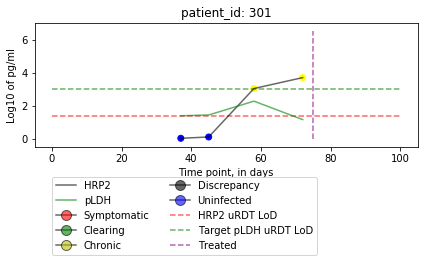

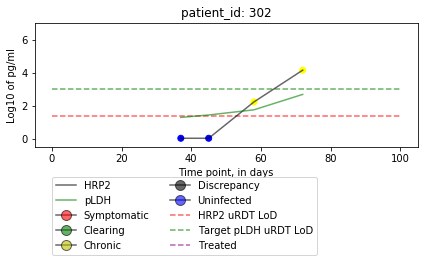

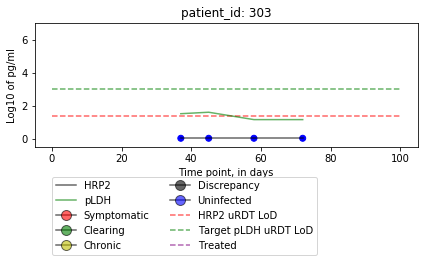

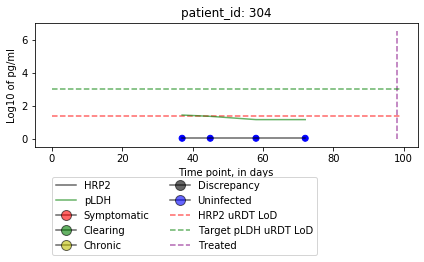

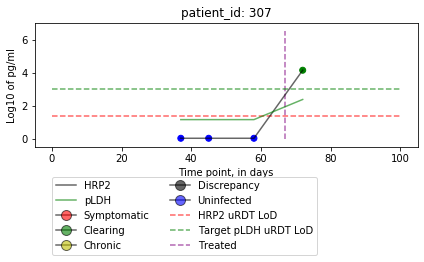

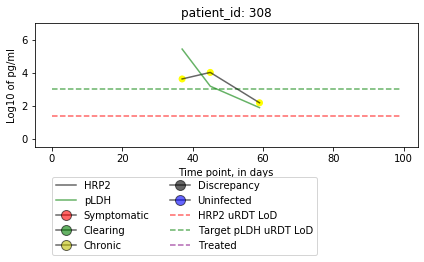

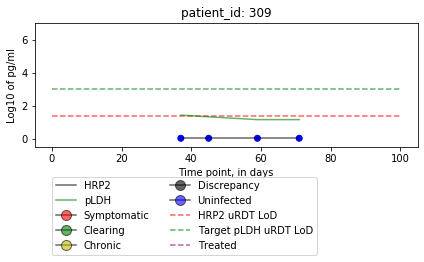

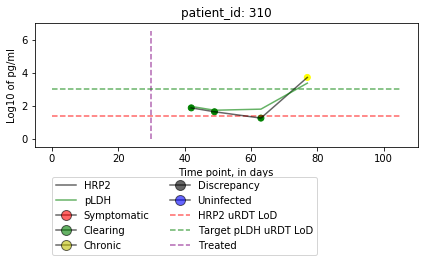

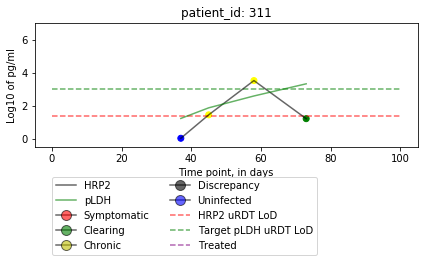

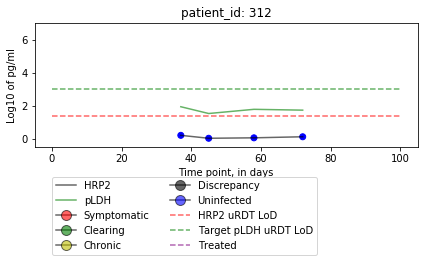

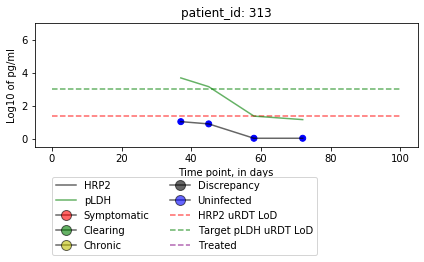

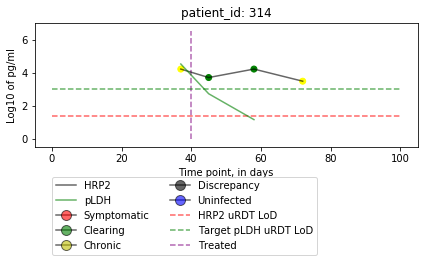

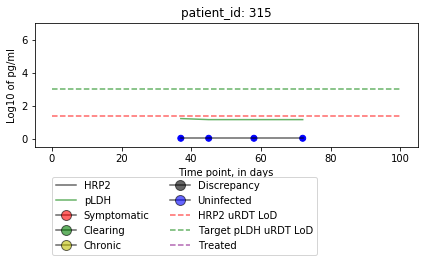

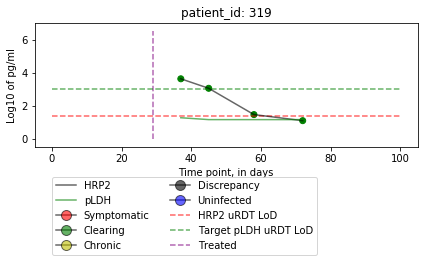

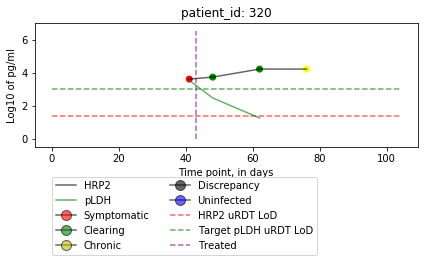

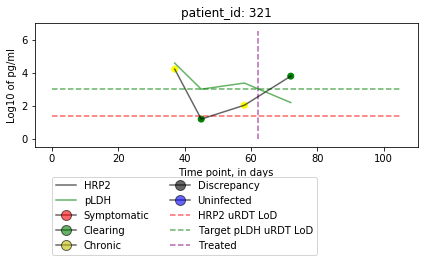

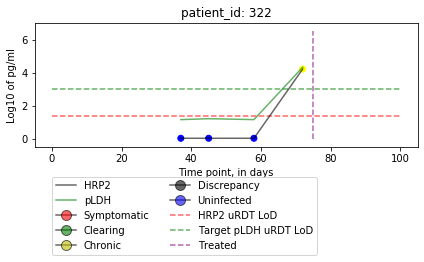

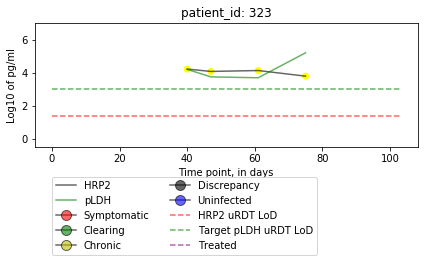

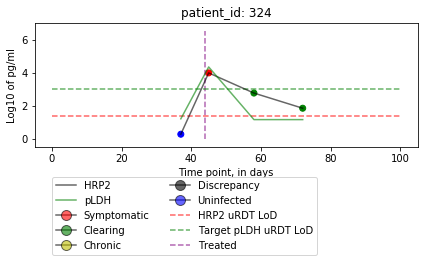

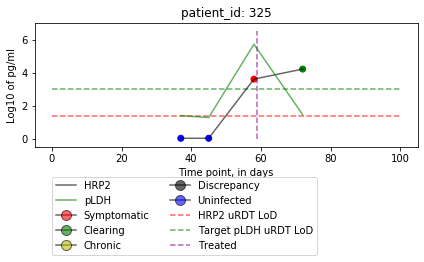

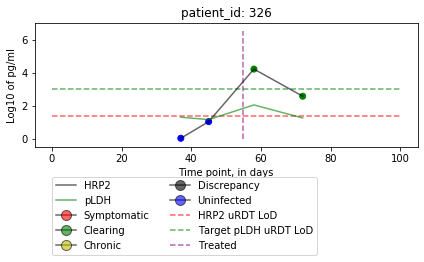

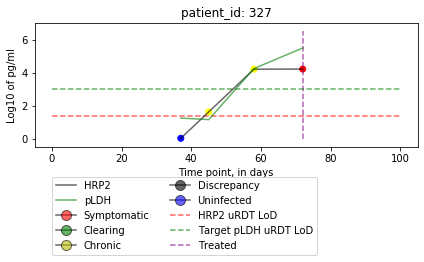

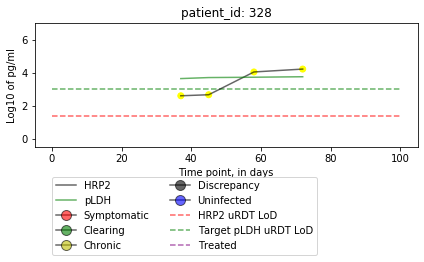

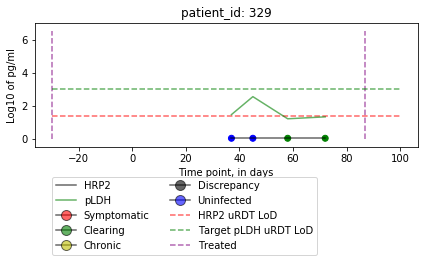

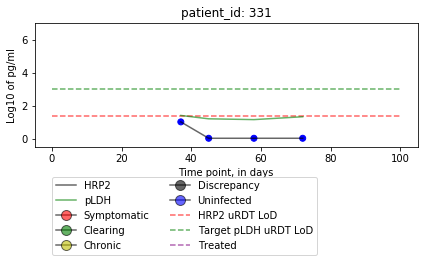

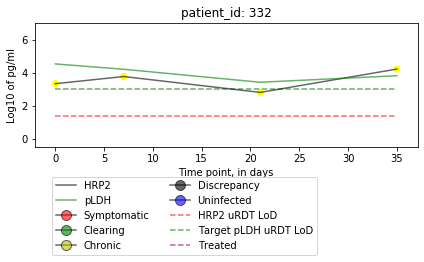

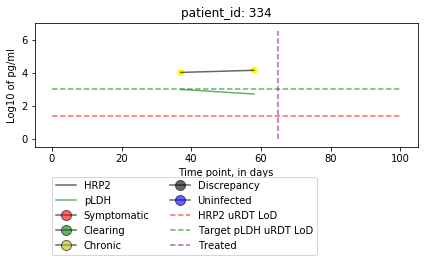

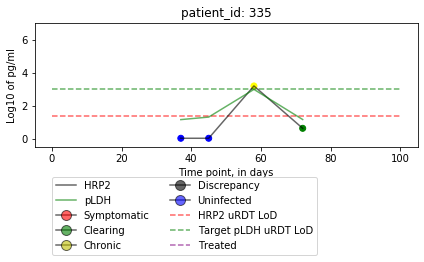

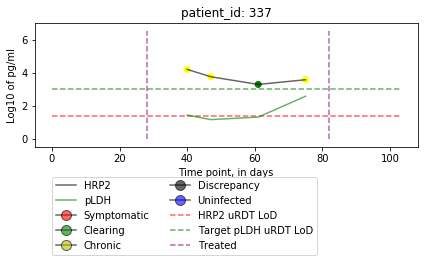

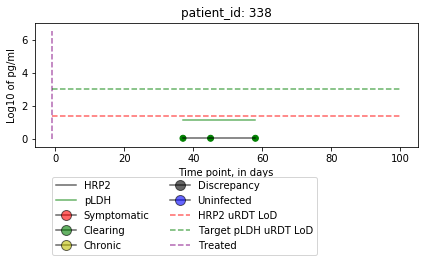

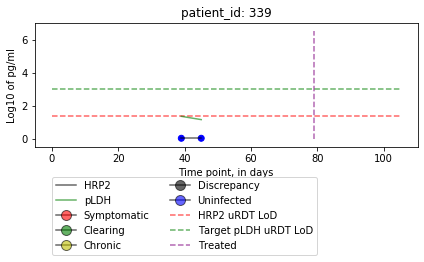

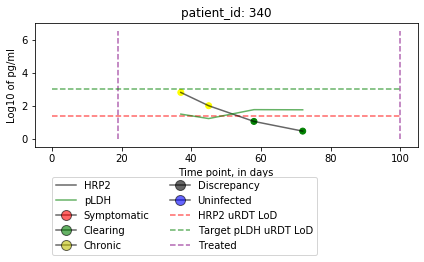

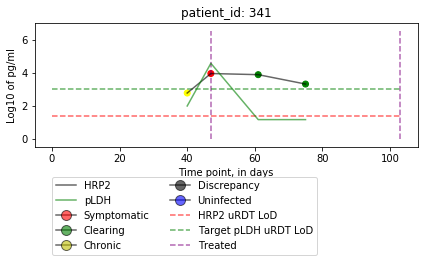

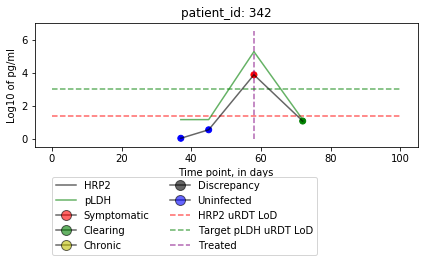

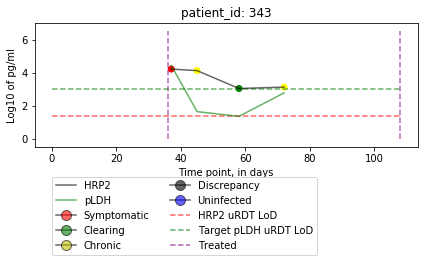

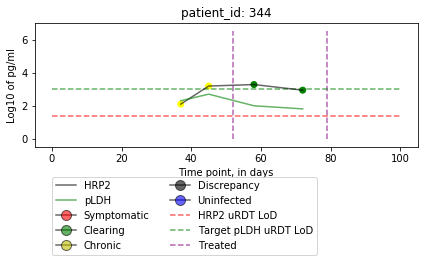

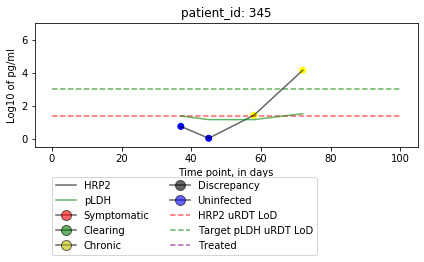

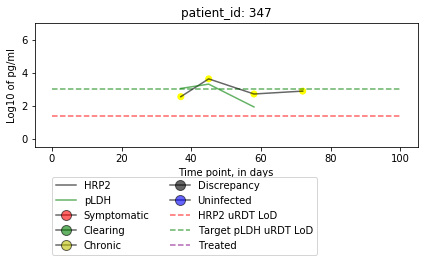

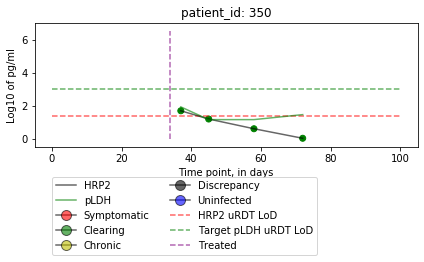

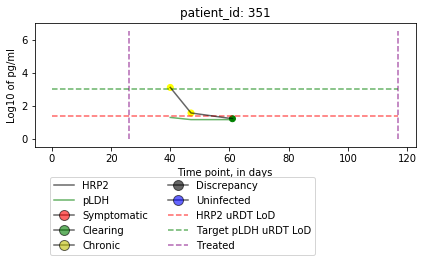

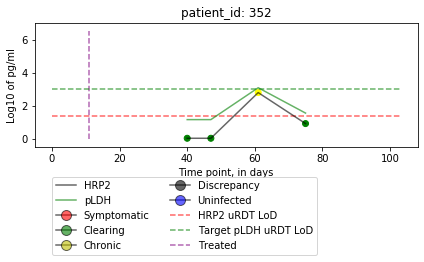

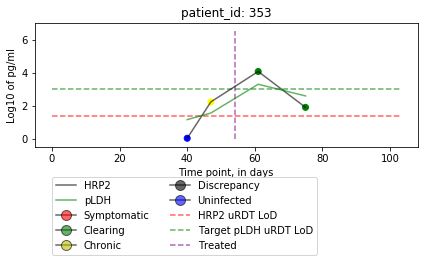

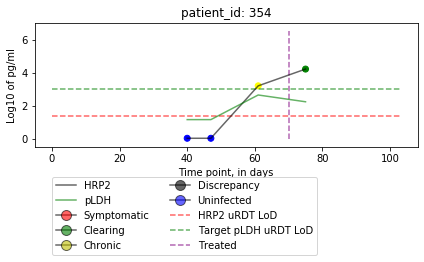

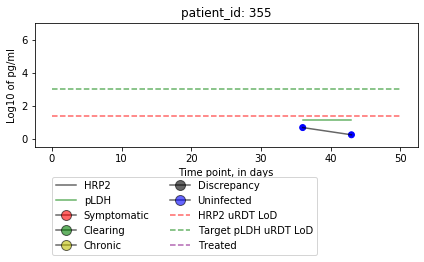

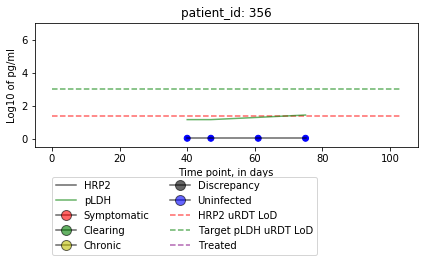

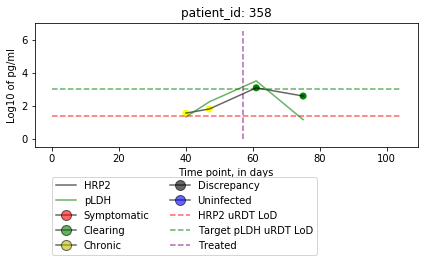

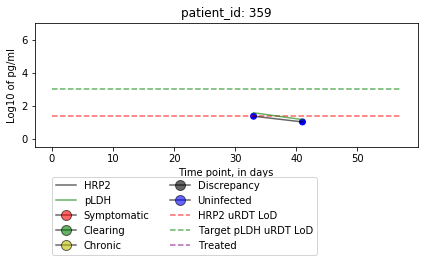

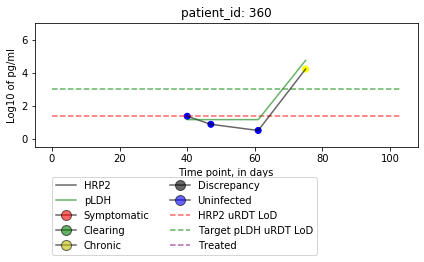

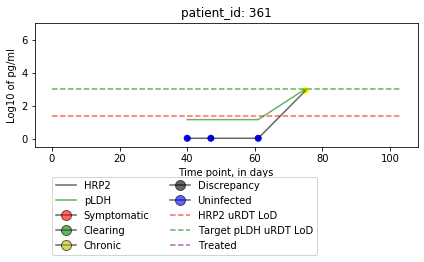

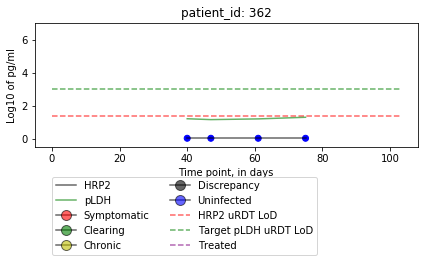

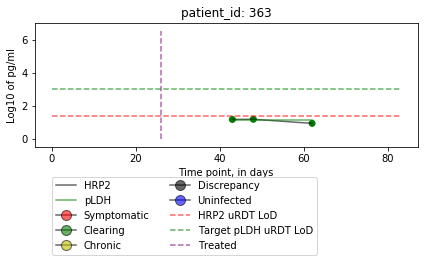

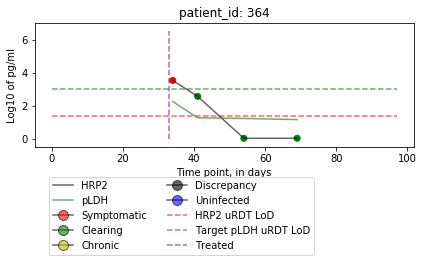

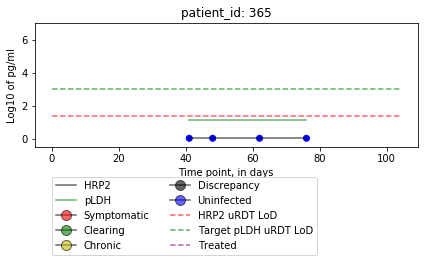

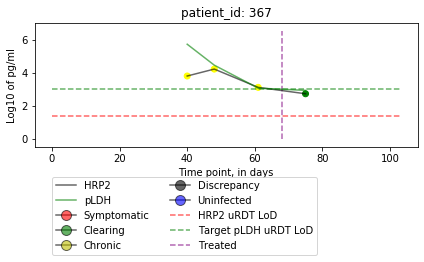

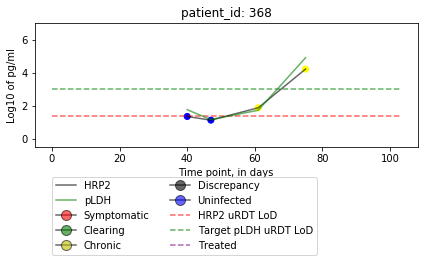

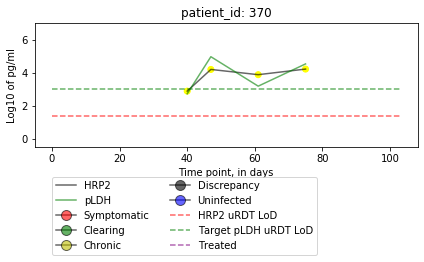

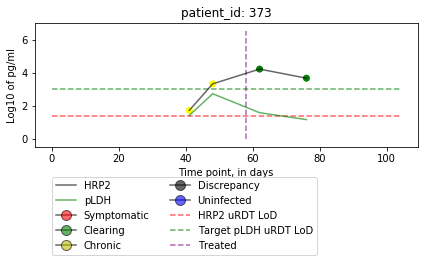

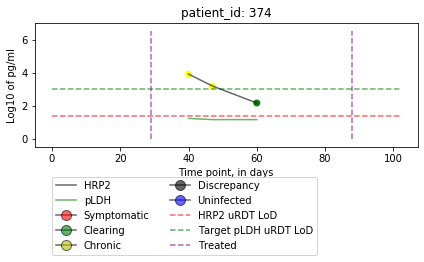

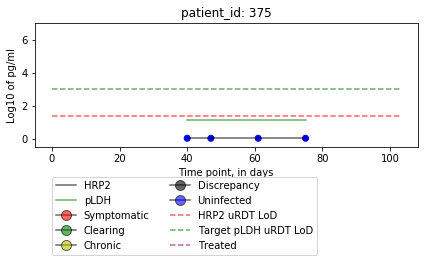

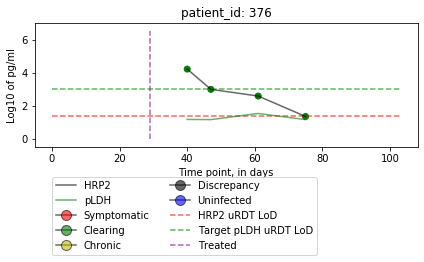

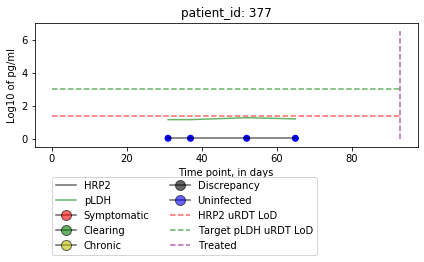

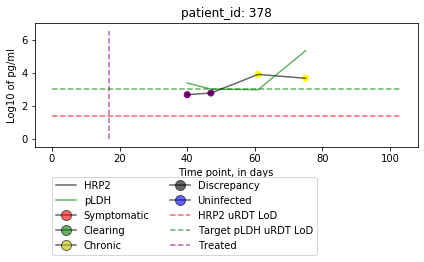

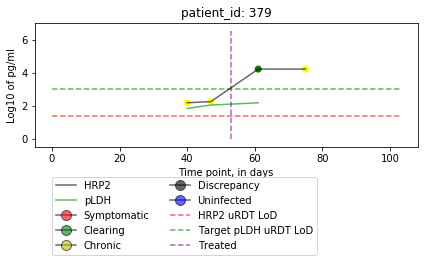

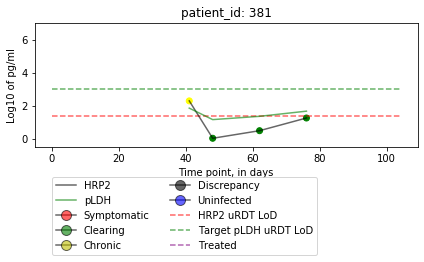

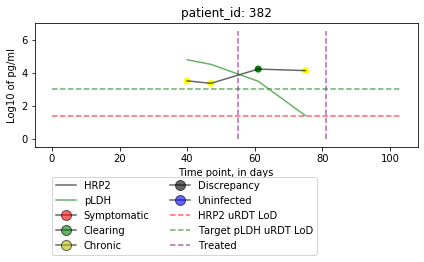

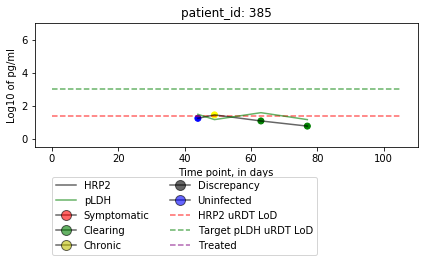

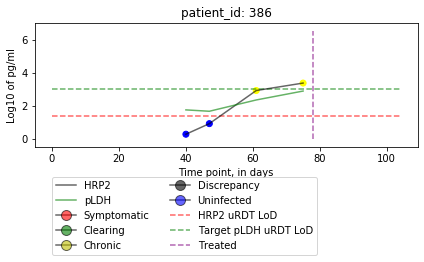

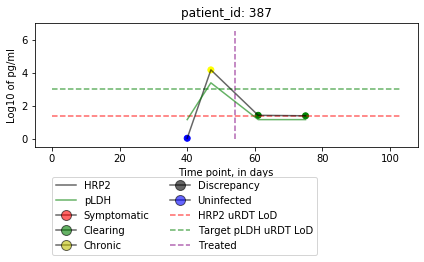

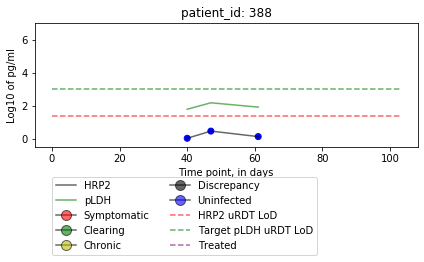

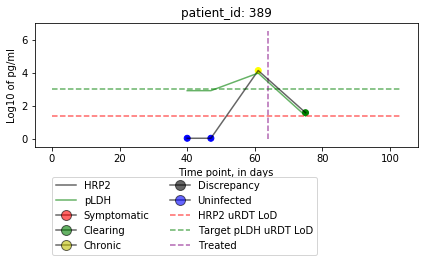

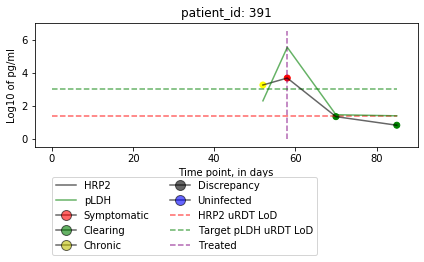

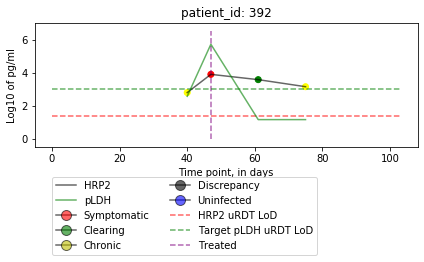

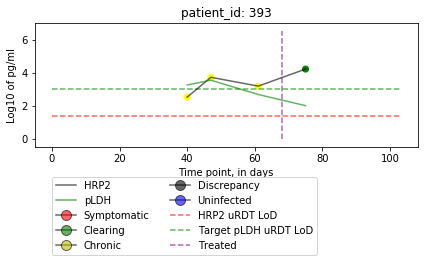

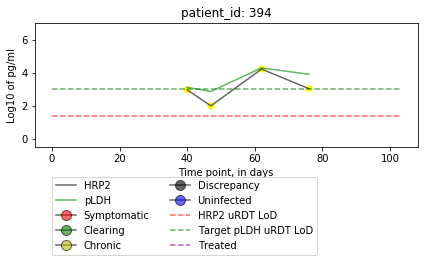

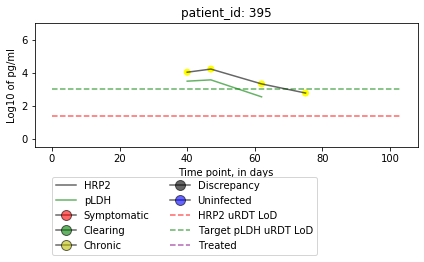

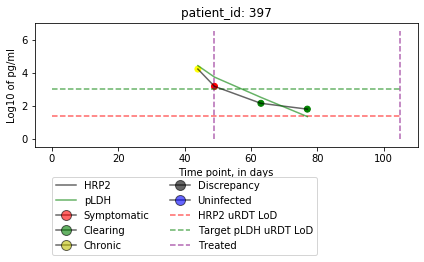

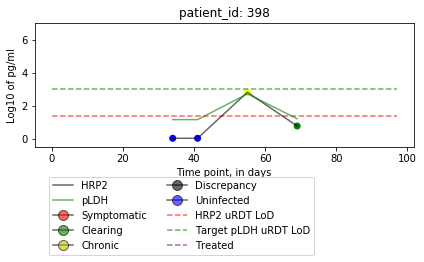

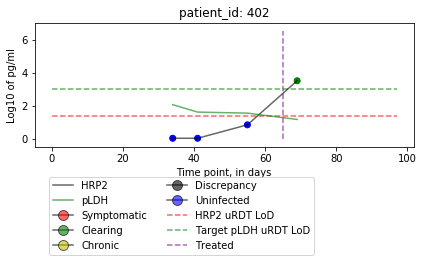

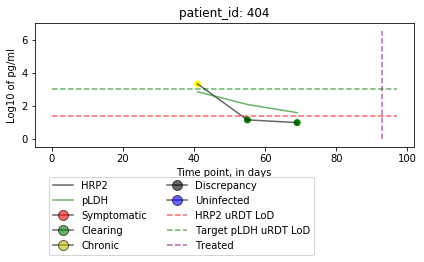

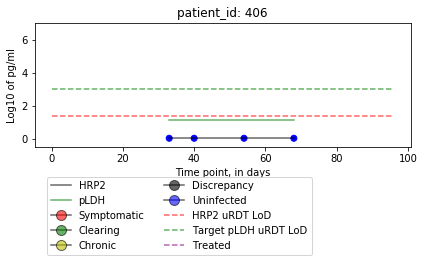

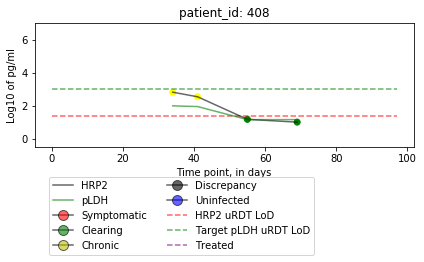

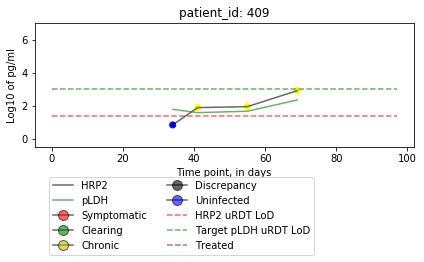

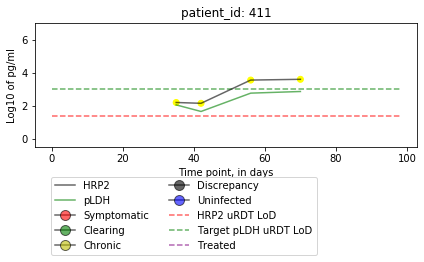

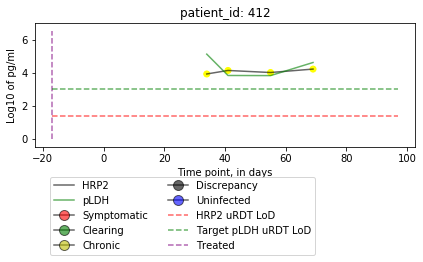

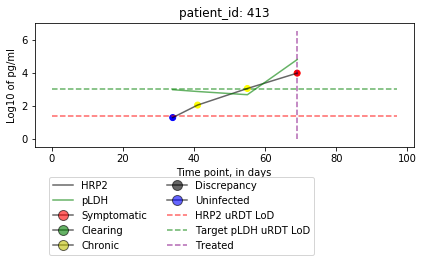

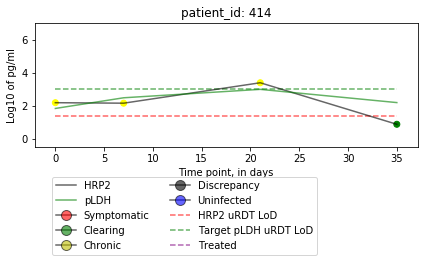

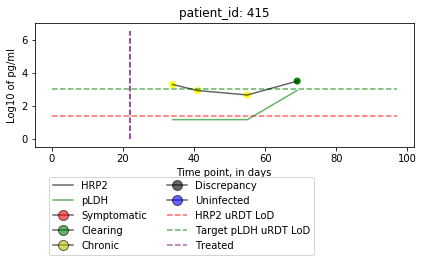

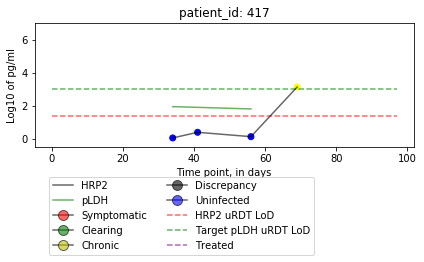

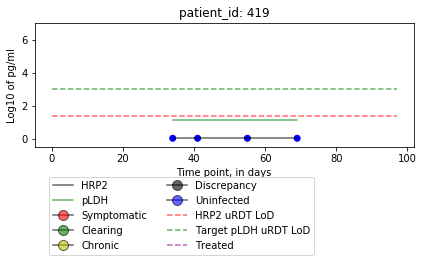

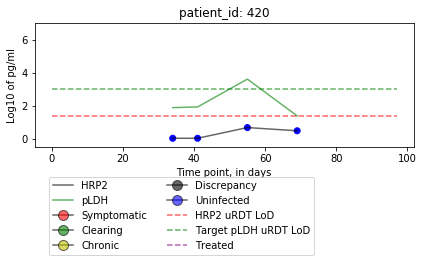

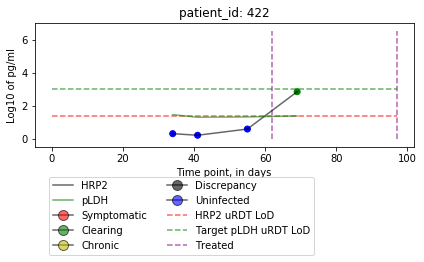

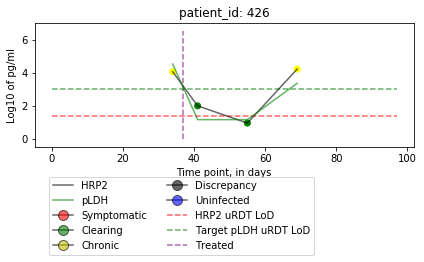

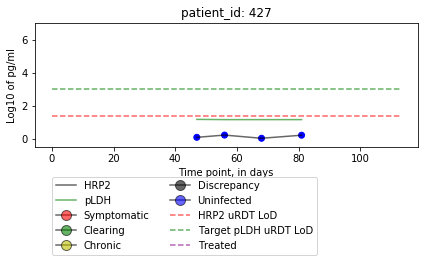

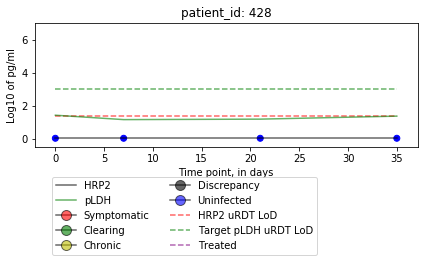

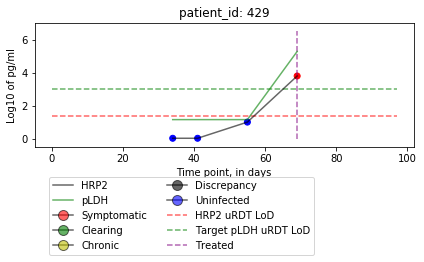

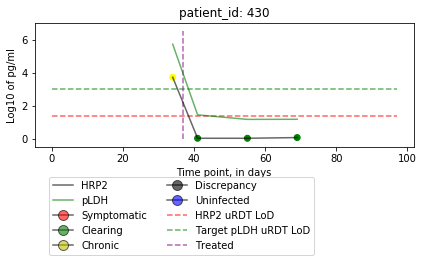

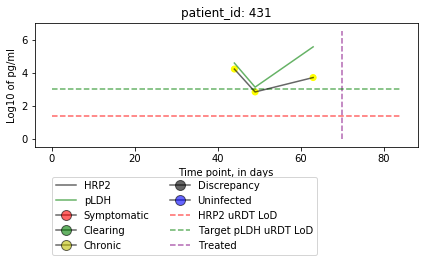

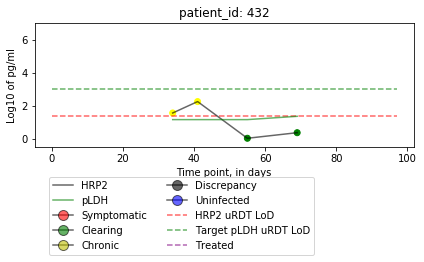

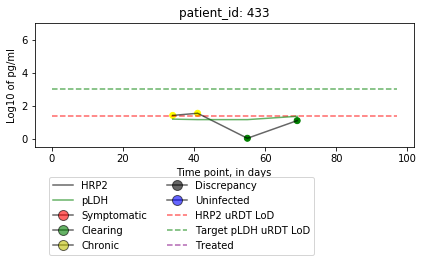

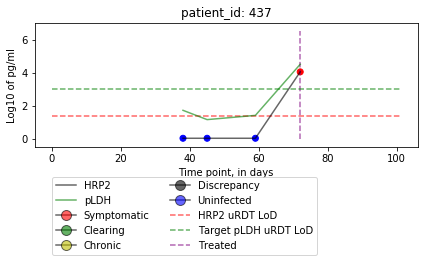

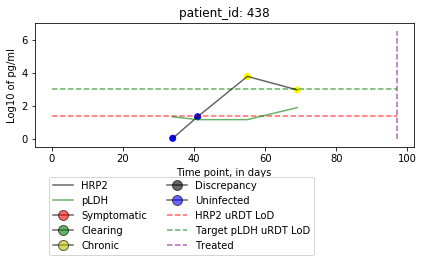

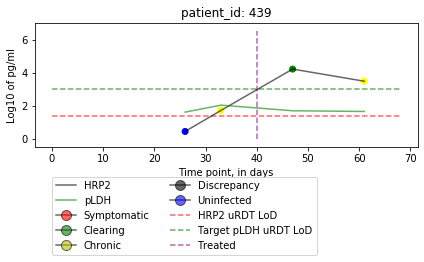

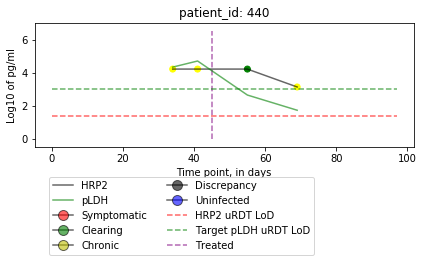

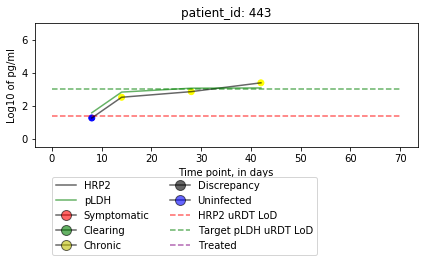

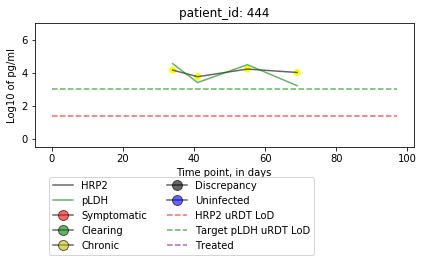

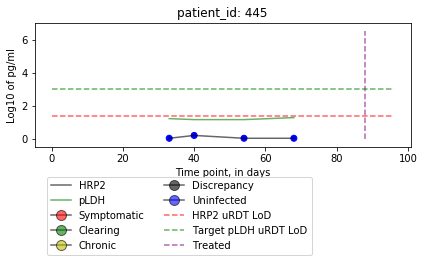

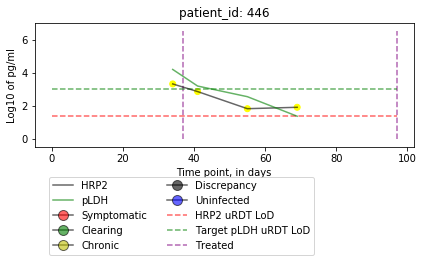

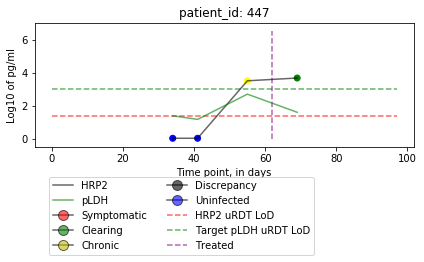

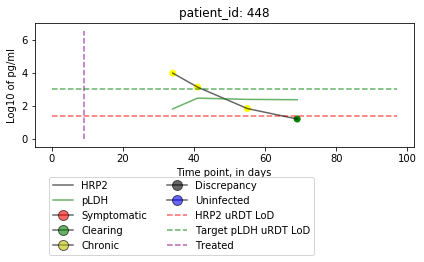

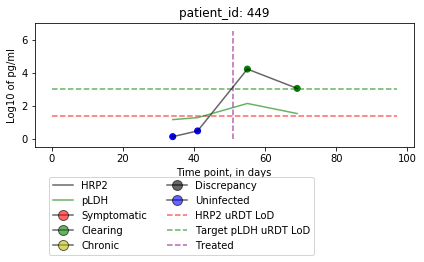

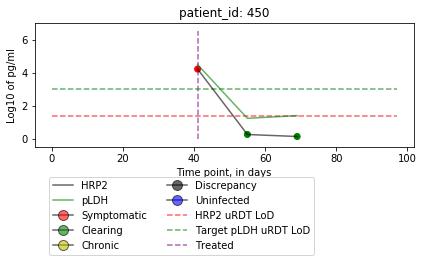

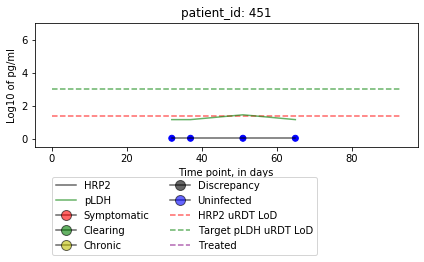

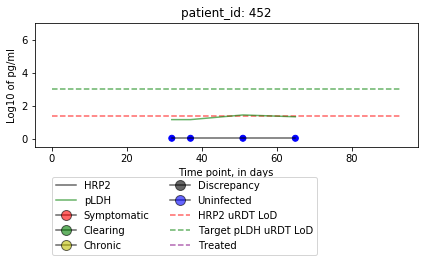

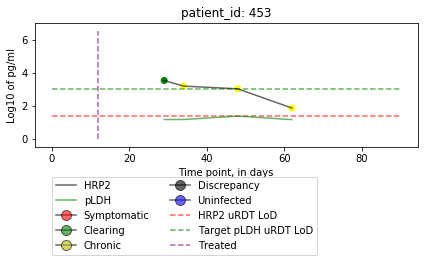

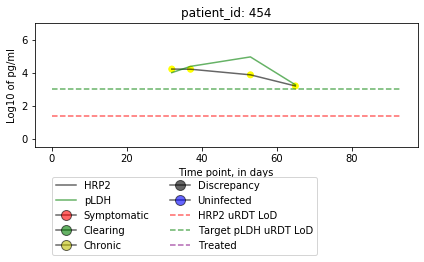

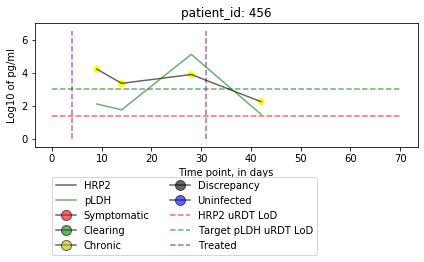

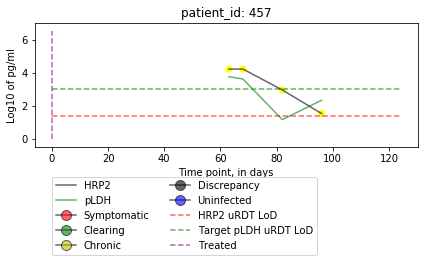

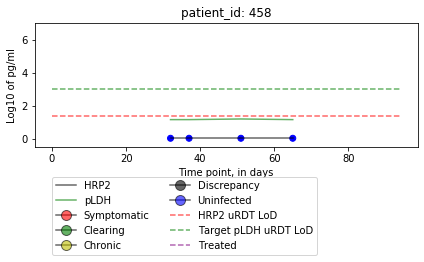

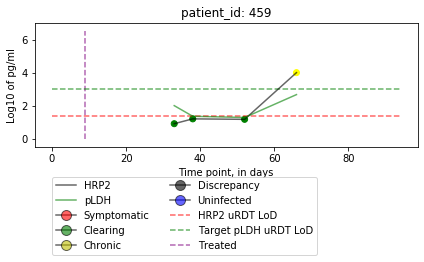

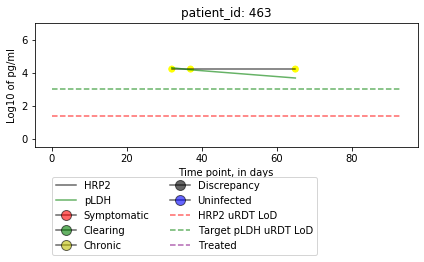

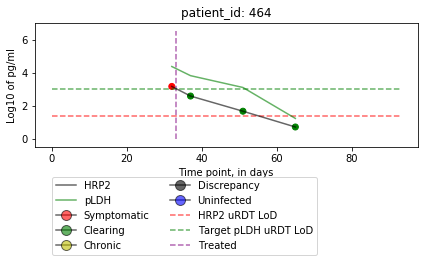

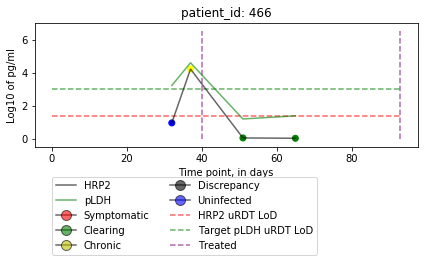

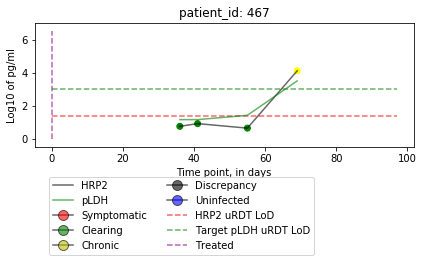

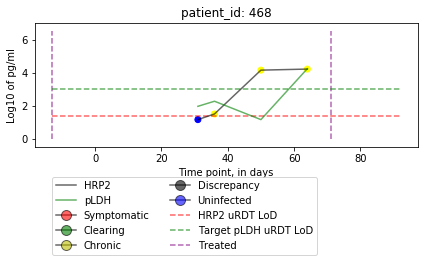

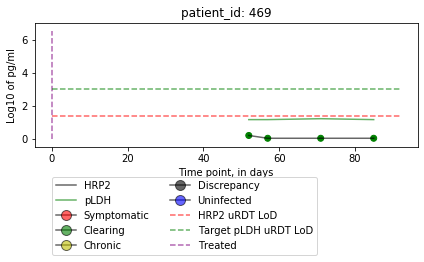

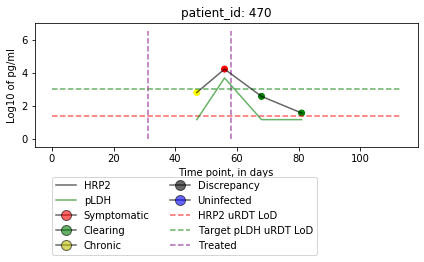

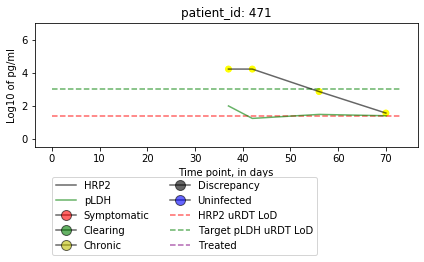

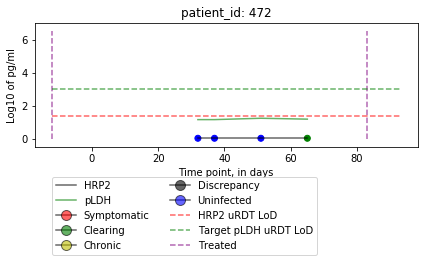

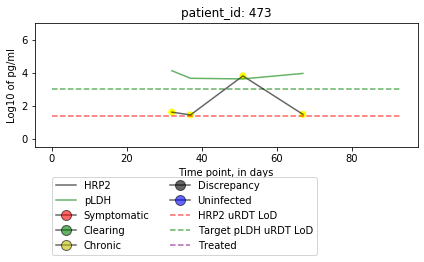

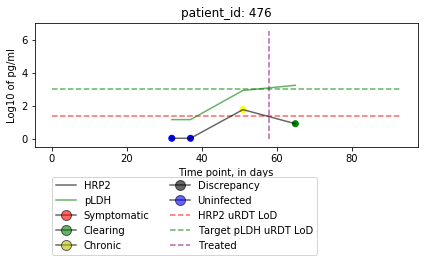

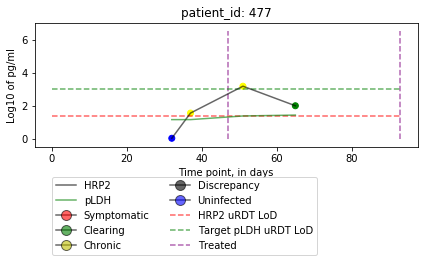

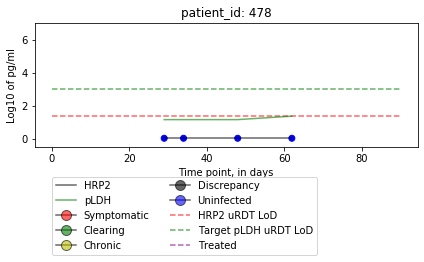

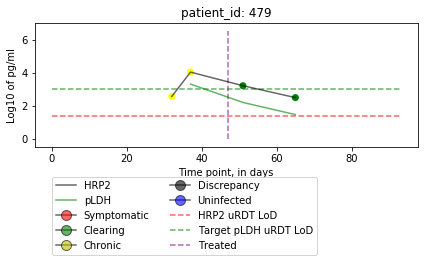

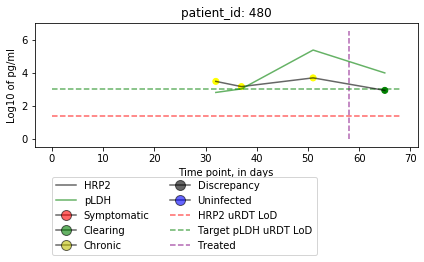

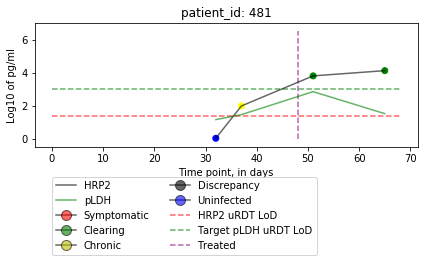

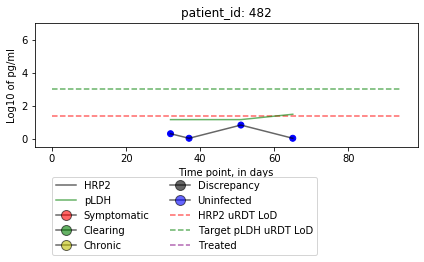

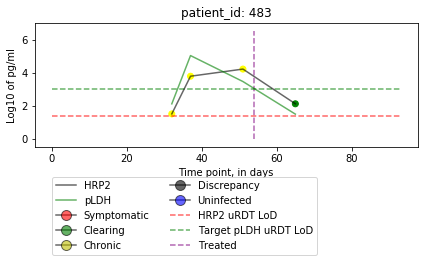

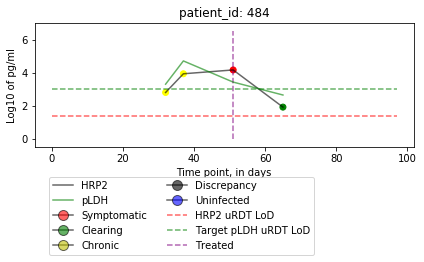

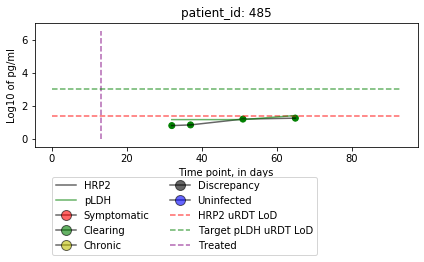

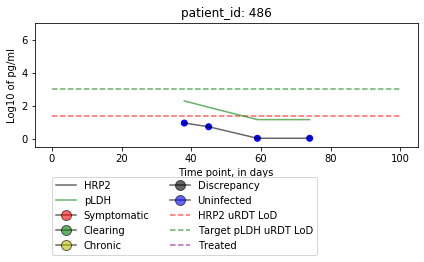

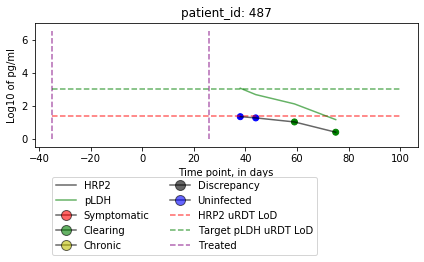

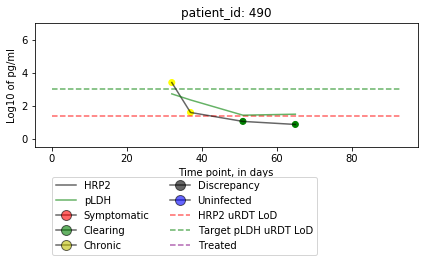

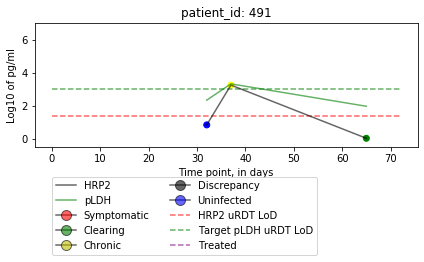

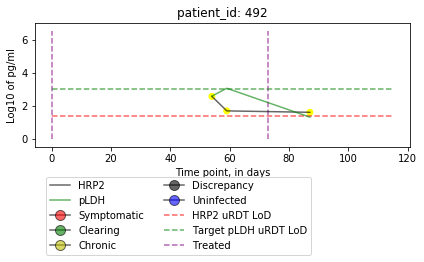

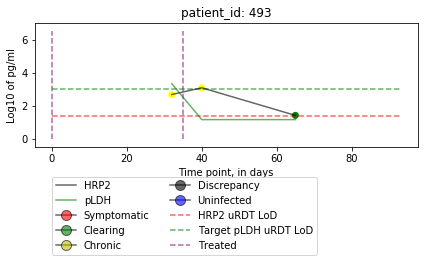

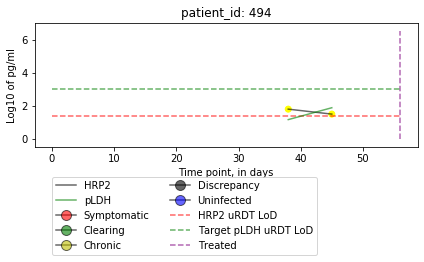

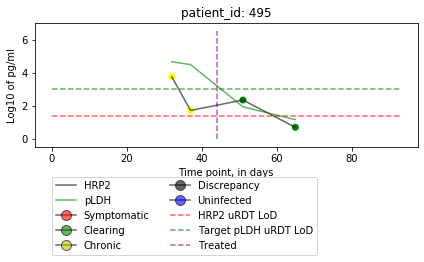

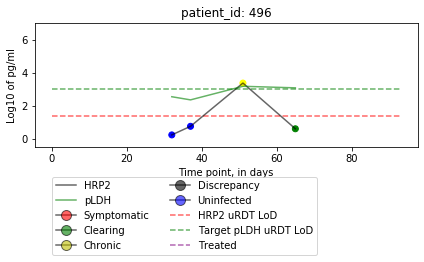

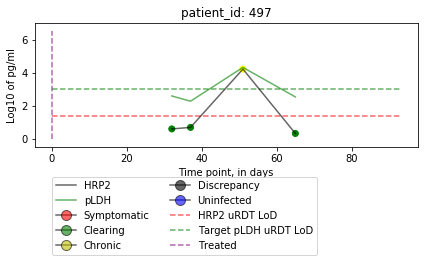

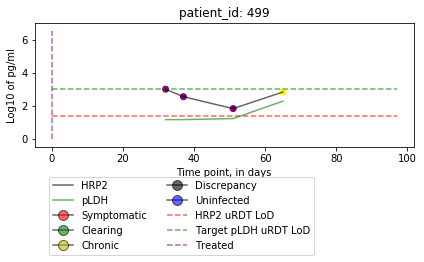

In [50]:
split_pdf = PdfPages('C:/Users/lzoeckler/Desktop/mali_meta/NIH_mali_class_attempt_day_split.pdf')
for pid in classed_data['participant_id'].unique():
    combo = classed_data.loc[classed_data['participant_id'] == pid]
    if len(combo) > 0:
        combo.sort_values('date_dif', inplace=True)
        for_line = combo.loc[~combo['HRP2_pg_ml'].isnull()]
        max_day = max(combo['date_dif'])
        min_day = min(combo['date_dif'])
        try:
            max_y = max([max(for_line['HRP2_pg_ml']), max(for_line['LDH_Pan_pg_ml'])])
            min_y = min([min(for_line['HRP2_pg_ml']), min(for_line['LDH_Pan_pg_ml'])])
        except ValueError:
            print(pid)
            continue
        f, ax1 = plt.subplots()
        age = combo['age_yrs'].unique()[0]
        treatment_days = combo.loc[~combo['drug'].isnull(), 'date_dif'].tolist()
        for day in treatment_days:
            ax1.plot(np.array([day, day]), np.array([0, 6.5]), color='purple',
                     linestyle='--', alpha=0.6)
        hrp2_urdt_lod = ax1.plot(np.array([min_day, max_day]), np.array([1.4, 1.4]),
                                 color='red', linestyle='--', alpha=0.6)
        hrp2_urdt_lod = ax1.plot(np.array([min_day, max_day]), np.array([3, 3]),
                                 color='green', linestyle='--', alpha=0.6)
        title = """patient_id: {}""".format(pid)
        ln4 = ax1.plot(for_line['date_dif'], for_line['HRP2_pg_ml'],
                       c='black', alpha=0.6, label='HRP2')
        ln3 = ax1.plot(for_line['date_dif'], for_line['LDH_Pan_pg_ml'],
                       c='green', alpha=0.6, label='pLDH')
        try:
            ax1.scatter(for_line['date_dif'], for_line['HRP2_pg_ml'], c=for_line['class'])
        except ValueError:
            print(pid)
            continue
        ax1.set_title(title)
        ax1.set_xlabel('Time point, in days')
        ax1.set_ylabel('Log10 of pg/ml')
        ax1.set_ylim([-.5, 7])

        # LINE STUFF
        lns = ln4 + ln3
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Symptomatic', markerfacecolor='r',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Clearing', markerfacecolor='g',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Chronic', markerfacecolor='y',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Discrepancy', markerfacecolor='k',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], marker='o', color='k', label='Uninfected', markerfacecolor='b',
                            markersize=10, alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='red', linestyle='--', label='HRP2 uRDT LoD', alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='green', linestyle='--', label='Target pLDH uRDT LoD', alpha=0.6)]
        lns = lns + [Line2D([0], [0], color='purple', linestyle='--', label='Treated', alpha=0.6)]
        labs = [l.get_label() for l in lns]
        ax1.legend(lns, labs, bbox_to_anchor=(.75, -.2), ncol=2)

        # Actually plot stuff
        plt.tight_layout()
        split_pdf.savefig(f)
        plt.show()
        plt.close()
    else:
        print(pid)
split_pdf.close()

In [12]:
len(classed_data)

2353